In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.animation import FuncAnimation

In [2]:
def create_data(n_samples:int, n_kernels:int):
    X, mu_list, sigma_list = [], [], []
    mu_list = np.random.uniform(-10, 10, n_kernels)
    sigma_list = np.ones(n_kernels)
    for mu, sigma in zip(mu_list, sigma_list):
        X_kernel = np.random.normal(loc=mu, scale=sigma, size=int(n_samples / n_kernels))
        X = np.append(X, X_kernel)
    return X, mu_list, sigma_list

In [3]:
def gaussian(mu, sigma):
    def f(x):
        return np.exp(-0.5 * (x - mu) ** 2 / sigma**2) / np.sqrt(2 * np.pi * sigma**2)

    return f

### 事後確率(posterior proba) の計算
$$
\gamma(z_{nk}) = \frac{\pi_k \cdot p(x_n|\theta_k)}{\sum_{j=1}^K \pi_j \cdot p(x_n|\theta_j)}
$$

ここで、
- $\gamma(z_{nk})$ は、データポイント $n$ がクラスタ $k$ に属する事後確率
- $\pi_k$ は混合係数（`mixing_coeff`）
- $p(x_n|\theta_k)$ は尤度（`likelihood`）
- $K$ はガウス分布の数

#### 入力
- `X`: データポイントの配列
- `mixing_coeff`: 混合係数（各ガウス分布の重み）
- `gauss_fn`: ガウス分布の確率密度関数を計算する関数

#### アルゴリズム
1. 尤度の計算
2. 非正規化事後確率の計算
3. 正規化定数の計算
4. 事後確率（負担率）の計算

#### 出力
- `posterior_proba`: 各データポイントが各ガウス分布に属する確率（負担率）

In [4]:
def calc_expectation(X, mixing_coeff, gauss_fn):
    likelihood = np.zeros((X.size, mixing_coeff.size))
    for i, x in enumerate(X):
        likelihood[i, :] = gauss_fn(x)
    unnormalized_posterior = mixing_coeff * likelihood
    normalization_constant = np.sum(unnormalized_posterior, axis=1).reshape(-1, 1)
    posterior_proba = unnormalized_posterior / normalization_constant
    return posterior_proba

### 尤度の最大化
1. 平均の更新:
   $$\mu_k^{new} = \frac{\sum_{n=1}^N \gamma(z_{nk})x_n}{\sum_{n=1}^N \gamma(z_{nk})}$$

2. 分散（標準偏差の二乗）の更新:
   $$(\sigma_k^{new})^2 = \frac{\sum_{n=1}^N \gamma(z_{nk})(x_n - \mu_k^{new})^2}{\sum_{n=1}^N \gamma(z_{nk})}$$

3. 混合係数の更新:
   $$\pi_k^{new} = \frac{1}{N}\sum_{n=1}^N \gamma(z_{nk})$$

#### 入力
- `X`: データポイントの配列
- `posterior_proba`: Eステップで計算された事後確率（負担率）

#### アルゴリズム

1. 有効サンプル数の計算:
2. 平均（μ）の更新:
3. 標準偏差（σ）の更新:
4. 混合係数（π）の更新:

#### 出力
- `mu`: 更新された各ガウス分布の平均
- `sigma`: 更新された各ガウス分布の標準偏差
- `mixing_coeff`: 更新された混合係数

In [5]:
def maximize_likelihood(X, posterior_proba):
    N = posterior_proba.sum(axis=0)
    mu = (posterior_proba * X.reshape((-1, 1))).sum(axis=0) / N
    sigma = np.sqrt((posterior_proba * (X.reshape(-1, 1) - mu) ** 2).sum(axis=0) / N)
    mixing_coeff = N / X.size
    return mu, sigma, mixing_coeff

### 対数尤度関数の計算

$$
Q(\theta, \theta_{old}) = \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk} \left[ \log \pi_k - \frac{1}{2} \log(2\pi\sigma_k^2) - \frac{(x_n - \mu_k)^2}{2\sigma_k^2} \right]
$$

ここで、
- $\gamma_{nk}$ は事後確率（責任値）
- $\pi_k$ は混合係数
- $\mu_k$ はk番目のガウス分布の平均
- $\sigma_k$ はk番目のガウス分布の標準偏差
- $x_n$ はn番目のデータポイント
- $N$ はデータポイントの総数
- $K$ はガウス分布の数

#### 入力
- `X`: データポイントの配列
- `mu`: 各ガウス分布の平均
- `sigma`: 各ガウス分布の標準偏差
- `mixing_coeff`: 混合係数
- `posteria_proba`: 事後確率（責任値）

#### アルゴリズム

1. Q 関数の初期化:
2. 各データポイントに対する Q 値の累積:

#### 出力
- `Q`: 計算された Q 関数の値

In [6]:
def calc_Q(X, mu, sigma, mixing_coeff, posteria_proba):
    Q = (
        posteria_proba * (np.log(mixing_coeff * (2 * np.pi * sigma**2) ** (-0.5)))
    ).sum()
    for i, x in enumerate(X):
        Q += (posteria_proba[i, :] * (-0.5 * (x - mu) ** 2 / sigma**2)).sum()
    return Q

In [7]:
n_kernels = 3
n_samples = 1500 * n_kernels
X, mu_list, sigma_list = create_data(n_samples, n_kernels)

In [8]:
mixing_coeff = np.random.rand(n_kernels)
mu = np.random.uniform(-10, 10, n_kernels)
sigma = np.abs(np.random.randn(n_kernels))
Q = -sys.float_info.max
delta = None

In [9]:
epsilon = 0.1
index = 0
mu_history = []
sigma_history = []
mixing_coeff_history = []
delta_history = []
while delta == None or delta >= epsilon:
    gauss_fn = gaussian(mu, sigma)
    posteria_proba = calc_expectation(X, mixing_coeff, gauss_fn)
    mu, sigma, mixing_coeff = maximize_likelihood(X, posteria_proba)
    if 0 in sigma:
        sigma = np.abs(np.random.randn(n_kernels))
        continue
    Q_new = calc_Q(X, mu, sigma, mixing_coeff, posteria_proba)
    delta = np.abs(Q_new - Q)
    Q = Q_new
    print(index, delta)
    mu_history.append(mu)
    sigma_history.append(sigma)
    mixing_coeff_history.append(mixing_coeff)
    delta_history.append(delta)
    index += 1

0 1.7976931348623157e+308
1 44.94298201165111
2 97.013698414803
3 93.49939607258602
4 84.73817181757113
5 77.42374140273569
6 71.17229493243394
7 64.87780848234797
8 57.89454814464625
9 50.172427052702915
10 42.08387381605826
11 34.1631482564444
12 26.89808112533501
13 20.61804205228509
14 15.46469660585717
15 11.4186895841558
16 8.354163152123874
17 6.096160821323792
18 4.4647505439279485
19 3.30069358261062
20 2.475453871093123
21 1.8913323142660374
22 1.476951570750316
23 1.181474591814549
24 0.9692483150411135
25 0.8154753268972854
26 0.702963934667423
27 0.6197903549909825
28 0.5576592917859671
29 0.5107710438278446
30 0.47504465646670724
31 0.4475868694080418
32 0.42632907633924333
33 0.4097786145975988
34 0.3968477591424744
35 0.38673560302595433
36 0.3788460284613393
37 0.37273040275249514
38 0.3680472892301623
39 0.36453392622024694
40 0.36198588934348663
41 0.3602424751261424
42 0.35917611072545697
43 0.3586846110320039
44 0.35868546700112347
45 0.359111588457381
46 0.3599081

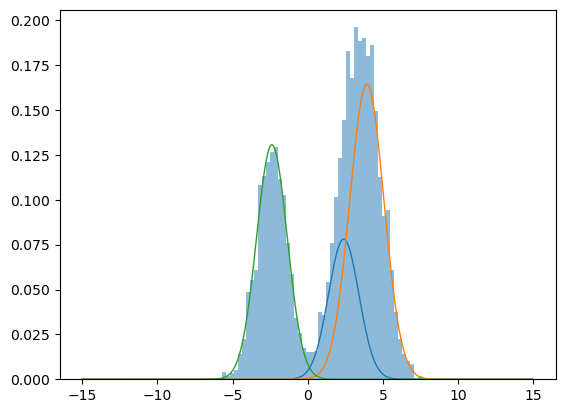

In [10]:
x= np.arange(-15, 15, 0.02)
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ["tab:blue", "tab:orange", "tab:green"]
ax.hist(X, bins=50, density=True, alpha=0.5)

for i in range(n_kernels):
    ax.plot(
        x,
        mixing_coeff_history[-1][i] * gaussian(mu_history[-1][i], sigma_history[-1][i])(x),
        linewidth=1.0,
        color=colors[i],
    )
plt.show()

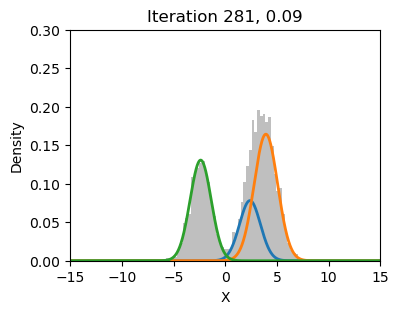

In [13]:
x = np.arange(-15, 15, 0.02)
fig, ax = plt.subplots(figsize=(4, 3))
colors = ["tab:blue", "tab:orange", "tab:green"]

ax.hist(X, bins=50, density=True, alpha=0.5, color="gray")

# 各ガウス分布のラインプロット（初期化）
lines = [ax.plot([], [], linewidth=2.0, color=colors[i])[0] for i in range(n_kernels)]

def update(frame):
    mu = mu_history[frame]
    sigma = sigma_history[frame]
    mixing_coeff = mixing_coeff_history[frame]

    for i in range(n_kernels):
        y = mixing_coeff[i] * gaussian(mu[i], sigma[i])(x)
        lines[i].set_data(x, y)

    ax.set_title(f"Iteration {frame}, {delta_history[frame]:.2f}")
    return lines


frames = len(mu_history)
ani = FuncAnimation(fig, update, frames=frames, interval=200, blit=True)

ax.set_xlim(-15, 15)
ax.set_ylim(0, 0.3)
ax.set_xlabel("X")
ax.set_ylabel("Density")

ani.save('em_algorithm.gif', writer='pillow', fps=5)